In [2]:

import os, sys

# Get the absolute path of the notebook's directory
notebook_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# # Add the parent directory to sys.path so we can import modules
sys.path.append(parent_dir)

# # Verify the path
print(f"Added to sys.path: {parent_dir}")

# # Add it to sys.path
sys.path.append(parent_dir)

print(sys.path)
# print(parent_dir)
# import torch
from localityaware.module import MLP
from NSGA_nn.nsga import *

Added to sys.path: /Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen
['/Users/panwapromtep/miniforge3/envs/torch/lib/python312.zip', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/lib-dynload', '', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/site-packages', '/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen', '/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen']
['/Users/panwapromtep/miniforge3/envs/torch/lib/python312.zip', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/lib-dynload', '', '/Users/panwapromtep/miniforge3/envs/torch/lib/python3.12/site-packages', '/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen', '/Users/panwapromtep/Library/CloudStorage/OneDrive-JohnsHopkins/Process Design/Aspen', '

In [3]:
import pickle
import torch

run_id = 'bnh/run_2025-04-20_15-57-53'


# Open out.pkl from the specified run_id
with open(f'./results/{run_id}/out.pkl', 'rb') as file:
    out = pickle.load(file)
print(out.keys())
y_path = out['y_path']
x_path = out['x_path']
assSim_call_count = out['assSim_call_count']
iteration_log = out['iteration_log']
populations = out['populations']
data_gen_time = out['data_gen_time']
total_original_assSim_calls = out['total_original_assSim_calls']

# Open scaler.pkl from the specified run_id
with open(f'./results/{run_id}/scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Load the model from the specified run_id
model = out['model']
model.eval()

dataset = out['dataset']
print("data_gen_time", data_gen_time)
import matplotlib.pyplot as plt


dict_keys(['model', 'x_path', 'y_path', 'dataset', 'assSim_call_count', 'populations', 'iteration_log', 'all_result', 'data_gen_time', 'total_assim_calls', 'total_original_assSim_calls'])
data_gen_time 0.0006821155548095703


1000
(1000, 2)


Text(0.5, 1.0, 'Initial Population Distribution')

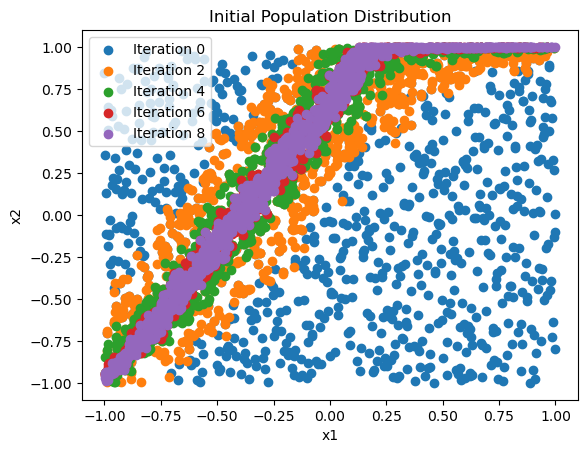

In [4]:
# number of population == number of iteration
print(len(populations[0]))
print(populations[0].shape)

# Initial populations of each run is 
for iter, pop in enumerate(populations):
    # Plot the population
    if iter % 2 ==0:
        plt.scatter(pop[:, 0], pop[:, 1], label=f"Iteration {iter}")
plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Initial Population Distribution")


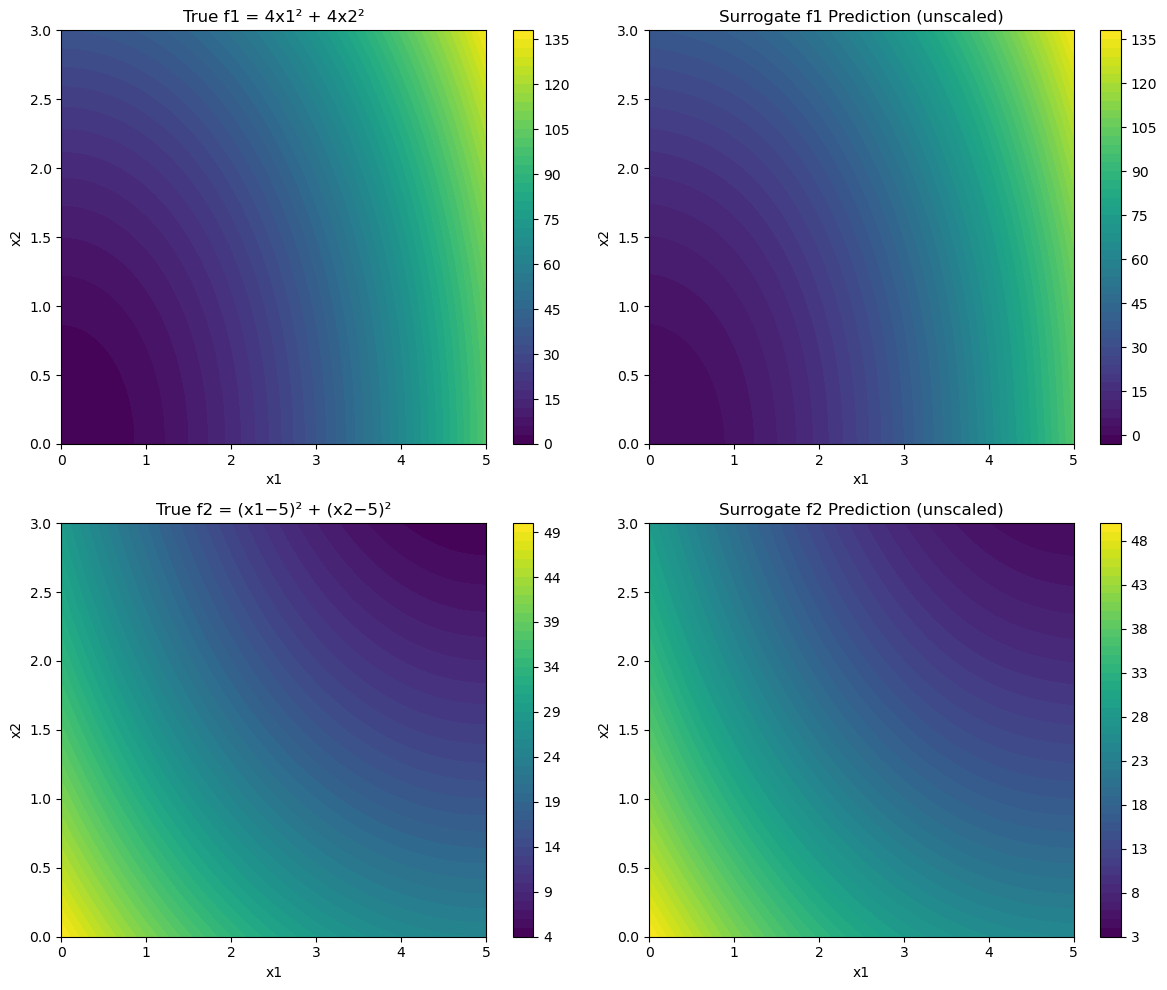

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Generate grid over x1 ∈ [0,5], x2 ∈ [0,3]
x1_vals = np.linspace(0, 5, 100)
x2_vals = np.linspace(0, 3, 100)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
grid = np.vstack([X1.ravel(), X2.ravel()]).T

# Compute true objectives
F1_true = 4 * grid[:, 0]**2 + 4 * grid[:, 1]**2
F2_true = (grid[:, 0] - 5)**2 + (grid[:, 1] - 5)**2

# Convert to torch and scale inputs
X_t = torch.tensor(grid, dtype=torch.float32)
Y_dummy = torch.zeros((grid.shape[0], 2), dtype=torch.float32)
X_scaled_t, _ = scaler.transform(X_t, Y_dummy)

# Predict scaled outputs with surrogate
model.eval()
with torch.no_grad():
    X_scaled_t = X_scaled_t.to('cpu')
    preds_scaled = model(X_scaled_t)

# Inverse-transform outputs back to original scale
_, preds_unscaled_t = scaler.inverse_transform(X_scaled_t, preds_scaled)
preds_unscaled = preds_unscaled_t.cpu().numpy()
F1_pred = preds_unscaled[:, 0].reshape(X1.shape)
F2_pred = preds_unscaled[:, 1].reshape(X1.shape)

# Reshape true values
F1_true = F1_true.reshape(X1.shape)
F2_true = F2_true.reshape(X1.shape)

# Plot true vs. surrogate for both objectives (unscaled)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# True f1
cs = axs[0, 0].contourf(X1, X2, F1_true, levels=50)
axs[0, 0].set_title('True f1 = 4x1² + 4x2²')
axs[0, 0].set_xlabel('x1')
axs[0, 0].set_ylabel('x2')
fig.colorbar(cs, ax=axs[0, 0])

# Surrogate f1
cs = axs[0, 1].contourf(X1, X2, F1_pred, levels=50)
axs[0, 1].set_title('Surrogate f1 Prediction (unscaled)')
axs[0, 1].set_xlabel('x1')
axs[0, 1].set_ylabel('x2')
fig.colorbar(cs, ax=axs[0, 1])

# True f2
cs = axs[1, 0].contourf(X1, X2, F2_true, levels=50)
axs[1, 0].set_title('True f2 = (x1−5)² + (x2−5)²')
axs[1, 0].set_xlabel('x1')
axs[1, 0].set_ylabel('x2')
fig.colorbar(cs, ax=axs[1, 0])

# Surrogate f2
cs = axs[1, 1].contourf(X1, X2, F2_pred, levels=50)
axs[1, 1].set_title('Surrogate f2 Prediction (unscaled)')
axs[1, 1].set_xlabel('x1')
axs[1, 1].set_ylabel('x2')
fig.colorbar(cs, ax=axs[1, 1])

plt.tight_layout()
plt.show()


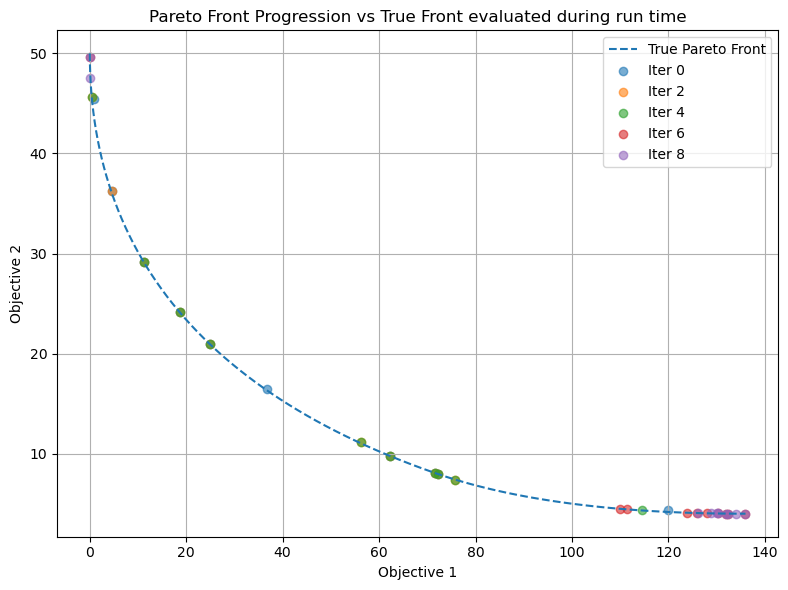

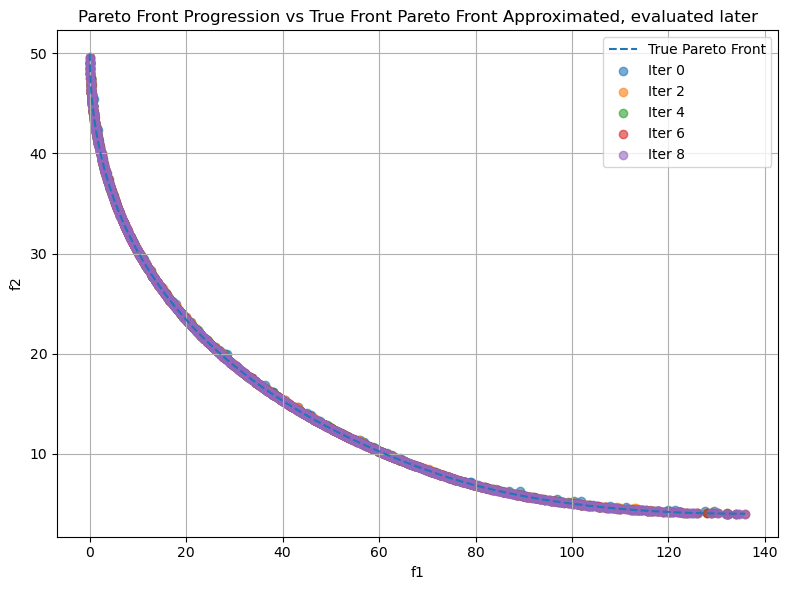

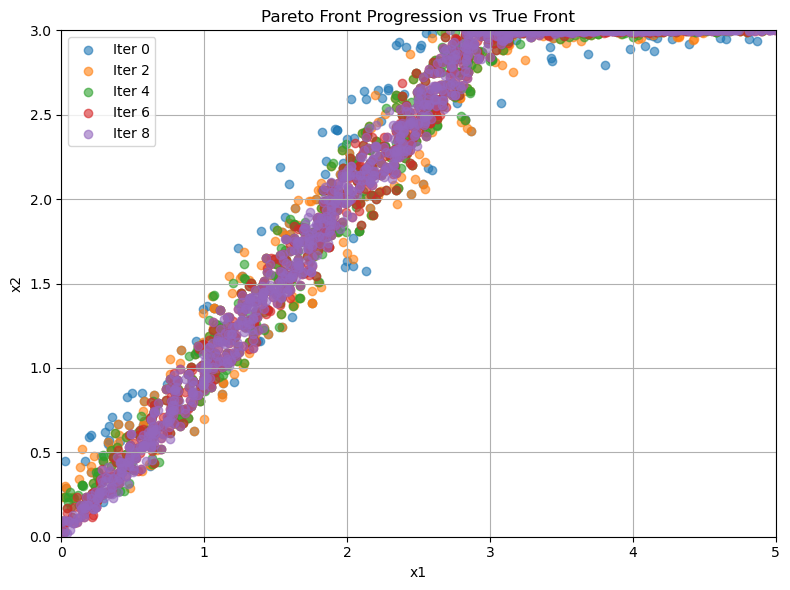

In [6]:
from pymoo.problems.multi import BNH
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1) Get the true Pareto front from pymoo
problem = BNH()
PF = problem.pareto_front()

# 2) Plot real front
plt.figure(figsize=(8, 6))
plt.plot(PF[:, 0], PF[:, 1], linestyle='--', label='True Pareto Front')

# 3) Overlay each iteration's front
for i, entry in enumerate(iteration_log):
    X_t = torch.tensor(entry['x'], dtype=torch.float32)
    Y_t = torch.tensor(entry['y'], dtype=torch.float32)
    if i % 2 == 0:
        plt.scatter(Y_t[:, 0], Y_t[:, 1], label=f'Iter {i}', alpha=0.6)

# 4) Labels and legend
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Pareto Front Progression vs True Front evaluated during run time')
plt.legend()
plt.grid(True)
plt.tight_layout()

#second plot
plt.figure(figsize=(8, 6))
plt.plot(PF[:, 0], PF[:, 1], linestyle='--', label='True Pareto Front')

for i, entry in enumerate(iteration_log):
    X_t = torch.tensor(entry['x'], dtype=torch.float32)
    if i % 2 == 0:
        #compute f1 and f2 based on X_t
        F1_true = 4 * X_t[:, 0]**2 + 4 * X_t[:, 1]**2
        F2_true = (X_t[:, 0] - 5)**2 + (X_t[:, 1] - 5)**2
        plt.scatter(F1_true,F2_true, label=f'Iter {i}', alpha=0.6)

plt.xlabel('f1')
plt.ylabel('f2')
plt.title('Pareto Front Progression vs True Front Pareto Front Approximated, evaluated later')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

        

#third plot
plt.figure(figsize=(8, 6))

# 3) Overlay each iteration's front
for i, entry in enumerate(iteration_log):
    X_t = torch.tensor(entry['x'], dtype=torch.float32)
    if i % 2 == 0:
        plt.scatter(X_t[:, 0], X_t[:, 1], label=f'Iter {i}', alpha=0.6)

# 4) Labels and legend
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Pareto Front Progression vs True Front')
plt.xlim(0,5)
plt.ylim(0,3)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



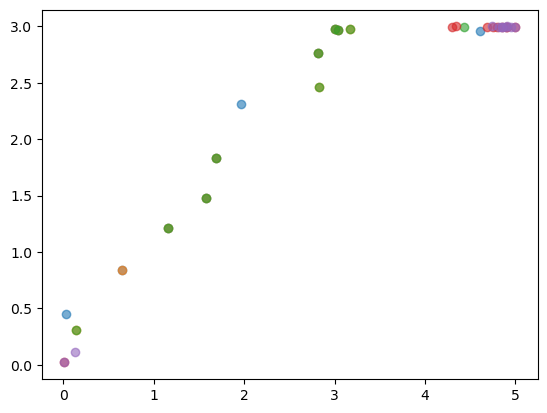

In [7]:
x_path = out["x_path"]
for i, entry in enumerate(x_path):
    X_t = torch.tensor(entry, dtype=torch.float32)
    if i % 2 == 0:
        plt.scatter(X_t[:, 0], X_t[:, 1], label=f'Iter {i}', alpha=0.6)

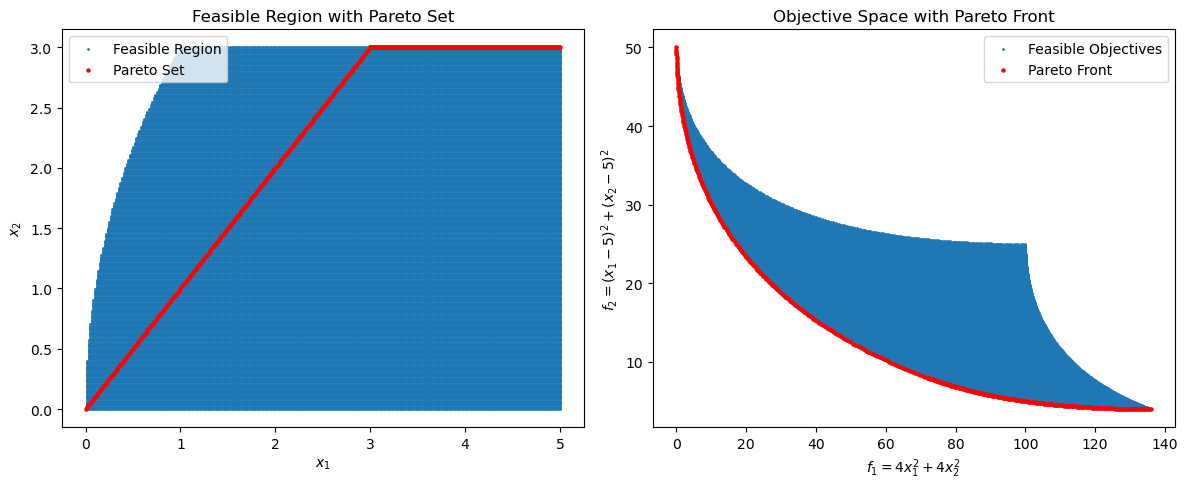

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the grid of x1 and x2 values in the feasible range
x1_vals = np.linspace(0, 5, 300)
x2_vals = np.linspace(0, 3, 300)
X1, X2 = np.meshgrid(x1_vals, x2_vals)

# Constraint evaluations
C1 = (X1 - 5)**2 + X2**2 <= 25
C2 = (X1 - 8)**2 + (X2 + 3)**2 >= 7.7
feasible = C1 & C2

# Extract feasible x1, x2
x1_feasible = X1[feasible]
x2_feasible = X2[feasible]

# Evaluate objectives for feasible points
f1_feasible = 4 * x1_feasible**2 + 4 * x2_feasible**2
f2_feasible = (x1_feasible - 5)**2 + (x2_feasible - 5)**2

# Define the analytical Pareto-optimal set
x1_pareto_1 = np.linspace(0, 3, 200)
x2_pareto_1 = x1_pareto_1

x1_pareto_2 = np.linspace(3, 5, 200)
x2_pareto_2 = np.full_like(x1_pareto_2, 3)

x1_pareto = np.concatenate([x1_pareto_1, x1_pareto_2])
x2_pareto = np.concatenate([x2_pareto_1, x2_pareto_2])

f1_pareto = 4 * x1_pareto**2 + 4 * x2_pareto**2
f2_pareto = (x1_pareto - 5)**2 + (x2_pareto - 5)**2

# Plot both feasible and Pareto sets
plt.figure(figsize=(12, 5))

# x-space plot
plt.subplot(1, 2, 1)
plt.scatter(x1_feasible, x2_feasible, s=1, label='Feasible Region')
plt.scatter(x1_pareto, x2_pareto, s=5, color='red', label='Pareto Set')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Feasible Region with Pareto Set")
plt.legend()

# f-space plot
plt.subplot(1, 2, 2)
plt.scatter(f1_feasible, f2_feasible, s=1, label='Feasible Objectives')
plt.scatter(f1_pareto, f2_pareto, s=5, color='red', label='Pareto Front')
plt.xlabel("$f_1 = 4x_1^2 + 4x_2^2$")
plt.ylabel("$f_2 = (x_1 - 5)^2 + (x_2 - 5)^2$")
plt.title("Objective Space with Pareto Front")
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
def generational_distance(F_approx: np.ndarray, F_true: np.ndarray) -> float:
    """
    Compute the Generational Distance (GD) between an approximate Pareto front and the true Pareto front.
    
    Parameters:
        F_approx (np.ndarray): An (n_points, n_objectives) array of approximate front points.
        F_true   (np.ndarray): A (m_points, n_objectives) array of true front points.
        
    Returns:
        float: The average Euclidean distance from each point in F_approx to the nearest point in F_true.
    """
    # Compute squared pairwise distances: shape (n_points, m_points)
    sq_dists = np.sum((F_approx[:, None, :] - F_true[None, :, :])**2, axis=2)
    # For each approx point, take the sqrt of the min squared distance (i.e., Euclidean distance)
    min_dists = np.sqrt(np.min(sq_dists, axis=1))
    # Return the average distance
    return np.mean(min_dists)


In [10]:
import pickle
nsga_run_id = "run_2025-04-20_15-47-55"
with open(f'./results/bnh_nsga/{nsga_run_id}/nsga.pkl', 'rb') as file:
    pure_res = pickle.load(file)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

surrogated  = out['all_result']

# — build the true front as before —
t1 = np.linspace(0, 3, 200)
f1_A = 4*t1**2 + 4*t1**2
f2_A = (t1 - 5)**2 + (t1 - 5)**2
t2 = np.linspace(3, 5, 200)
f1_B = 4*t2**2 + 4*3**2
f2_B = (t2 - 5)**2 + (3 - 5)**2
F_true = np.vstack([
    np.column_stack([f1_A, f2_A]),
    np.column_stack([f1_B, f2_B])
])


# — helper to extract per‐gen GD from a single res.history —
def gd_from_res(res):
    fronts = []
    for gen in res.history:
        F    = gen.pop.get("F")
        fronts.append(F)
    return [generational_distance(f, F_true) for f in fronts]

# — compute GD curves —
# 1) flatten all surrogate‐iterations into one long GD curve
gd_surr_iter = [gd for r in surrogated for gd in gd_from_res(r)]
gens_surr = np.arange(0, len(gd_surr_iter))

# 2) pure NSGA GD (will be length = n_gen)
gd_pure = gd_from_res(pure_res)
gens_pure = np.arange(0, len(gd_pure))

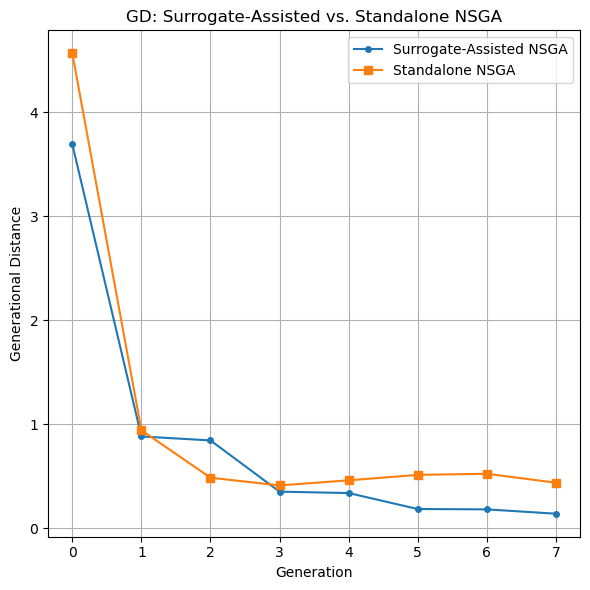

In [23]:
import matplotlib.pyplot as plt

# 1) Create a square figure
fig, ax = plt.subplots(figsize=(6, 6))   # 6×6 inches = square

# 2) Plot your two GD curves
ax.plot(gens_surr[:8], gd_surr_iter[:8], '-o', markersize=4,
        label='Surrogate‑Assisted NSGA')
ax.plot(gens_pure[:8],  gd_pure[:8],     '-s', markersize=6,
        label='Standalone NSGA')



# 4) Labels, legend, grid
ax.set_xlabel("Generation")
ax.set_ylabel("Generational Distance")
ax.set_title("GD: Surrogate‑Assisted vs. Standalone NSGA")
ax.legend()
ax.grid(True)
# ax.set_box_aspect(1)
plt.tight_layout()
plt.show()


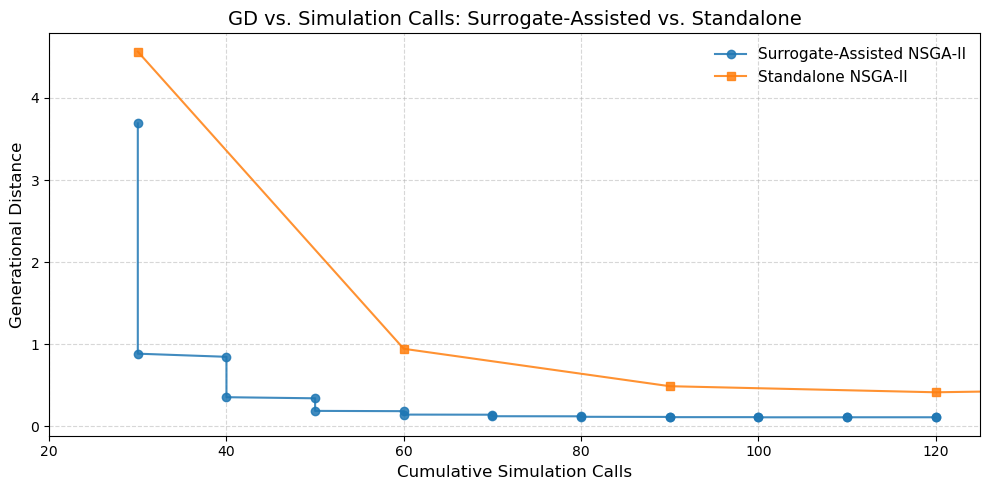

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Reconstruct or load call counts
initial      = 30
calls_per_it = 10
iter_total   = 10
pts_per_iter = len(gd_surr_iter) // iter_total
simCalls_surr = initial + (np.arange(len(gd_surr_iter)) // pts_per_iter) * calls_per_it
simCalls_nsga = np.arange(1, len(gd_pure)+1) * initial

# 2) Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(simCalls_surr, gd_surr_iter,
        marker='o', markersize=6, linestyle='-',
        label='Surrogate‑Assisted NSGA‑II', alpha=0.85)

ax.plot(simCalls_nsga, gd_pure,
        marker='s', markersize=6, linestyle='-',
        label='Standalone NSGA‑II', alpha=0.85)

ax.set_xlabel("Cumulative Simulation Calls", fontsize=12)
ax.set_ylabel("Generational Distance", fontsize=12)
ax.set_title("GD vs. Simulation Calls: Surrogate‑Assisted vs. Standalone", fontsize=14)

ax.legend(frameon=False, fontsize=11, loc='upper right')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.xlim(20,125)
plt.show()
